## Coleta de dados

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
from scipy.stats import chi2_contingency

In [2]:
def make_capital(x):
    try:
        return x.capitalize()
    except:
        return x
    

df = pd.DataFrame()
for year in range(2019, 2024):
    df_year = pd.read_excel('dados.xlsx', str(year))
    df = pd.concat([df, df_year])
    
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)
df.dropna(subset='medEnv', inplace=True)
df['medEnv'] = df['medEnv'].apply(lambda x: make_capital(x)).apply(lambda x: x.replace(' ', ''))

/var/data/python/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/var/data/python/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/var/data/python/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/var/data/python/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/var/data/python/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
df

,Date,UniClin,Pac,NumSes,Age,Sex,medEnv,ProbRelacPrim,ProbRelacSec,ObsProRel,StratIntervPrim,StratIntervSec,ObsStratInterv,EqpAssist,AvalAdes,"Preencha nos casos ""NAJ""\n (independente da categoria assistencial)"
0,2019-06-29,A,ERS,1023280,79,Masculino,Ácidozoledrônico,Prescrição,Duração do tratamento prescrita inadequada,NaN,Alteração na prescrição,Suspensão de medicamento,NaN,Médica,A,NaN
1,2019-01-21,C,JBS,7371596,84,Masculino,Bromoprida,Prescrição,Dose abaixo das recomendações (subdose),NaN,Alteração na prescrição,Aumento de dosagem (clínico),NaN,Médica,A,NaN
2,2019-11-28,A,ESO,1350321,53,Masculino,Dipirona,Prescrição,Outros problemas de prescrição,Possível farmacodermia? Síndrome de Stevens-Jo...,Alteração na prescrição,Substituição de medicamento por questões técni...,Sugerimos à equipe médica substituir dipirona ...,Médica,NaN,NaN
3,2019-11-28,A,ESO,1350321,53,Masculino,Dipirona,Prescrição,Outros problemas de prescrição,Possível farmacodermia? Síndrome de Stevens-Jo...,Alteração na prescrição,Substituição de medicamento por questões técni...,Sugerimos à equipe médica substituir dipirona ...,Médica,NaN,NaN
4,2019-11-28,A,ESO,1350321,53,Masculino,Fenitoína,Prescrição,Outros problemas de prescrição,Possível farmacodermia? Síndrome de Stevens-Jo...,Alteração na prescrição,Suspensão de medicamento,Sugerimos à equipe médica suspender medicamento.,Médica,A,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,2023-03-09,C,MSBM,1829745,62,Feminino,Valproatodesódio,Prescrição,Forma farmacêutica ou via de administração pr...,NaN,Alteração na prescrição,Substituição de medicamento por questões técni...,NaN,Médica,A,NaN
782,2023-06-13,A,SF,7866286,62,Masculino,Valproatodesódio,Prescrição,Frequência ou horários de administração presc...,Readequação das orientações acerca da frequênc...,Alteração na prescrição,Alteração na posologia/horários de administração,NaN,Médica,A,NaN
783,2023-06-26,A,APN,692747,77,Masculino,Valproatodesódio,Prescrição,Forma farmacêutica ou via de administração pr...,Prescrito Valproato de sódio comprimido para f...,Alteração na prescrição,Alteração na forma farmacêutica / via de admin...,Alterado para xarope,Médica,A,NaN
784,2023-05-18,A,APR,8126830,78,Feminino,Venlafaxina,Prescrição,Outros problemas de prescrição,Trocar de 2cp de 75mg para 1cp ed 150mg,Alteração na prescrição,Outras alterações na prescrição,NaN,Médica,A,NaN


In [4]:
df['year'] = df['Date'].apply(lambda x: x.year)
df['month'] = df['Date'].apply(lambda x: x.month)

### 1. Quais são os medicamentos mais solicitados, ao longo do tempo?

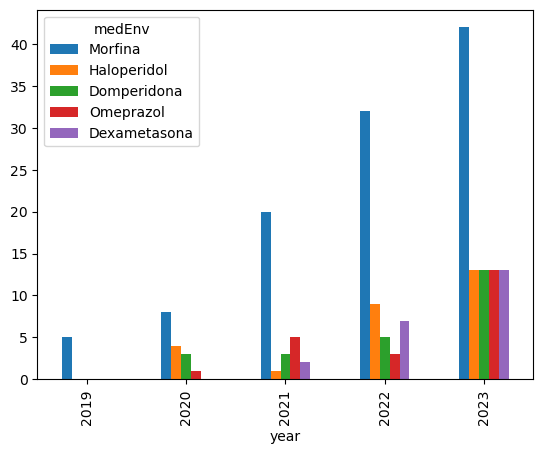

In [318]:
top_5 = df.groupby('medEnv').count().sort_values('Pac', ascending = False).head(5).index.to_list()
df_medenv_per_year = pd.pivot_table(df, values='Pac', index=['year'], aggfunc='count', columns='medEnv')[top_5].plot(use_index=True, kind='bar')#.sort_values(2023, ascending=False)

In [267]:
df.pivot_table(index='medEnv', columns='year', values='Pac', aggfunc='count').sort_values(2023, ascending=False).head(11).replace(np.nan, 0)

year,2019,2020,2021,2022,2023
medEnv,,,,,
Morfina,5.0,8.0,20.0,32.0,42.0
Haloperidol,0.0,4.0,1.0,9.0,13.0
Domperidona,0.0,3.0,3.0,5.0,13.0
Omeprazol,0.0,1.0,5.0,3.0,13.0
Dexametasona,0.0,0.0,2.0,7.0,13.0
Quetiapina,0.0,0.0,5.0,3.0,11.0
Ondansetrona,0.0,0.0,2.0,1.0,10.0
Dipirona,2.0,1.0,1.0,5.0,9.0
Bromoprida,1.0,4.0,2.0,5.0,9.0


 ### 2. Qual(is) é(são) as equipes mais acionadas, ao longo do tempo.

<Axes: ylabel='year'>

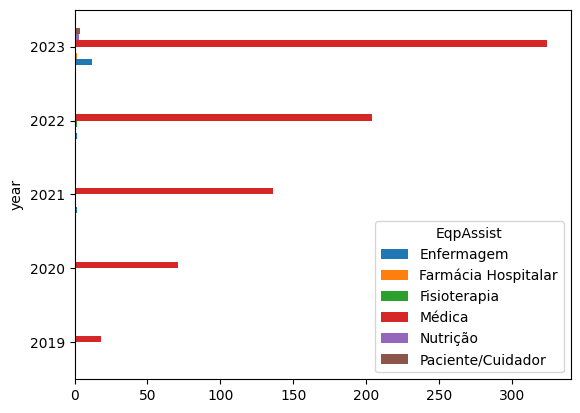

In [5]:
df_eqpassist_per_year = pd.pivot_table(df, values='Pac', index=['year'], aggfunc='count', columns='EqpAssist')#.plot(use_index=True)#.sort_values(2023, ascending=False)
df_eqpassist_per_year.plot(use_index=True, kind='barh')#.sort_values(2023, ascending=False)

In [269]:
df.pivot_table(index='EqpAssist', columns='year', values='Pac', aggfunc='count').sort_values(2023, ascending=False).replace(np.nan, 0)

year,2019,2020,2021,2022,2023
EqpAssist,,,,,
Médica,19.0,71.0,138.0,205.0,324.0
Enfermagem,0.0,0.0,2.0,2.0,12.0
Paciente/Cuidador,0.0,0.0,0.0,0.0,4.0
Nutrição,0.0,1.0,0.0,0.0,3.0
Farmácia Hospitalar,0.0,0.0,0.0,0.0,2.0
Fisioterapia,0.0,0.0,0.0,2.0,0.0


### 3. Correlação entre problema primário e secundário

<Axes: ylabel='ProbRelacPrim'>

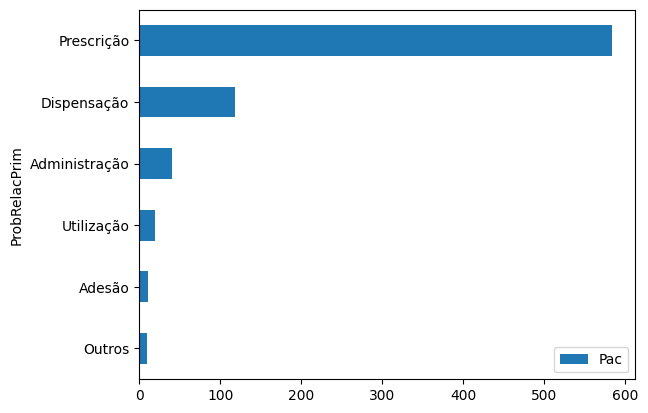

In [195]:
df.groupby('ProbRelacPrim').count()[['Pac']].sort_values('Pac').plot(kind='barh')

In [196]:
np.unique(df.groupby(['ProbRelacSec']).count()[['Pac']].sort_values('Pac').index.to_list())#.head(5).plot(kind='barh')

array([' (descrever na coluna "Observações")',
       ' Automedicação indevida pelo paciente',
       ' Conservação/preparo inadequado (diluente/estabilidade)',
       ' Descontinuação indevida do medicamento pelo paciente',
       ' Disponibilidade de alternativa medicamentosa mais custo efetiva',
       ' Dose abaixo das recomendações (subdose)',
       ' Dose acima das recomendação (sobredose)',
       ' Dose/concentração inadequada', ' Dose/quantidade incorreta',
       ' Duração do tratamento prescrita inadequada',
       ' Efeitos de descontinuação de um medicamento',
       ' Falta de adesão ao tratamento pelo paciente',
       ' Falta no estoque', ' Forma farmacêutica incorreta',
       ' Forma farmacêutica ou via de administração prescrita inadequada',
       ' Frequência ou horários de administração prescritos inadequados',
       ' Horário/frequência inadequada',
       ' Incompatibilidade medicamentosa contraindicada',
       ' Interação medicamento-medicamento contraindica

In [197]:
np.unique(df.groupby(['ProbRelacSec']).count()[['Pac']].sort_values('Pac').index.to_list())

array([' (descrever na coluna "Observações")',
       ' Automedicação indevida pelo paciente',
       ' Conservação/preparo inadequado (diluente/estabilidade)',
       ' Descontinuação indevida do medicamento pelo paciente',
       ' Disponibilidade de alternativa medicamentosa mais custo efetiva',
       ' Dose abaixo das recomendações (subdose)',
       ' Dose acima das recomendação (sobredose)',
       ' Dose/concentração inadequada', ' Dose/quantidade incorreta',
       ' Duração do tratamento prescrita inadequada',
       ' Efeitos de descontinuação de um medicamento',
       ' Falta de adesão ao tratamento pelo paciente',
       ' Falta no estoque', ' Forma farmacêutica incorreta',
       ' Forma farmacêutica ou via de administração prescrita inadequada',
       ' Frequência ou horários de administração prescritos inadequados',
       ' Horário/frequência inadequada',
       ' Incompatibilidade medicamentosa contraindicada',
       ' Interação medicamento-medicamento contraindica

### 4. Correlação entre problema primário e estratégia primária

<Axes: ylabel='StratIntervPrim'>

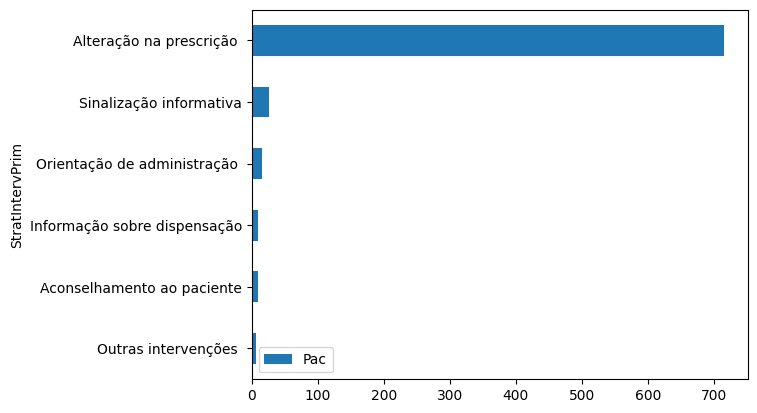

In [198]:
df.groupby('StratIntervPrim').count()[['Pac']].sort_values('Pac').plot(kind='barh')

In [199]:
crosstab_prp_sip = pd.crosstab(df.StratIntervPrim, df.ProbRelacPrim)
crosstab_prp_sip.transpose()

StratIntervPrim,Aconselhamento ao paciente,Alteração na prescrição,Informação sobre dispensação,Orientação de administração,Outras intervenções,Sinalização informativa
ProbRelacPrim,,,,,,
Adesão,3,6,2,0,0,0
Administração,0,24,1,8,4,4
Dispensação,0,109,6,1,2,0
Outros,0,3,0,0,0,7
Prescrição,3,568,0,5,0,7
Utilização,3,5,1,2,0,8


Text(0.5, 53.2222222222222, 'Problema Relacionado Primário')

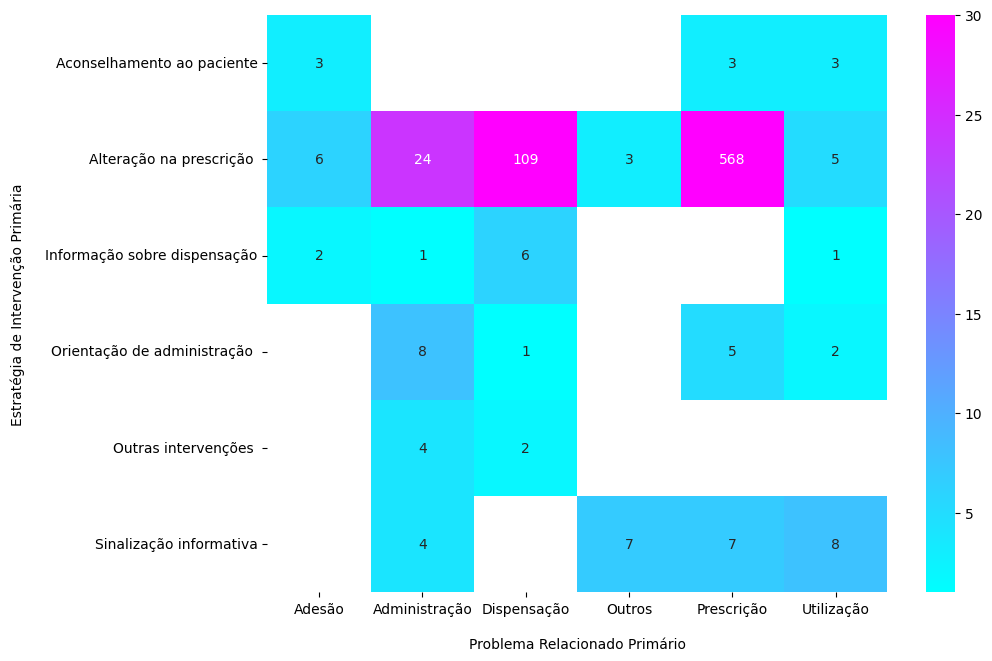

In [204]:
plt.figure(figsize=(10, 7.5))
ax = sns.heatmap(crosstab_prp_sip.replace(0, np.nan), cmap='cool', annot=True, fmt=".0f", vmax=30)
ax.set_ylabel('Estratégia de Intervenção Primária', labelpad=15)
ax.set_xlabel('Problema Relacionado Primário', fontsize=10, labelpad=15)


In [302]:
print('chi2 = ', chi2_contingency(crosstab_prp_sip)[0])
print('p = ', chi2_contingency(crosstab_prp_sip)[1])

chi2 =  524.6908274678444
p =  5.821625895699256e-95


### 5. Correlação entre problema primário e avaliação de adesão

In [306]:
df.groupby('AvalAdes').count()[['Pac']].sort_values('Pac')#.plot(kind='barh')

,Pac
AvalAdes,
NAJ,22
A,707


In [208]:
crosstab_prp_aa = pd.crosstab(df.ProbRelacPrim, df.AvalAdes)
crosstab_prp_aa

AvalAdes,A,NA,NAJ
ProbRelacPrim,,,
Adesão,9,2,0
Administração,35,5,1
Dispensação,115,2,1
Outros,6,4,0
Prescrição,526,37,20
Utilização,12,7,0


(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'A'), Text(0, 1.5, 'NA'), Text(0, 2.5, 'NAJ')])

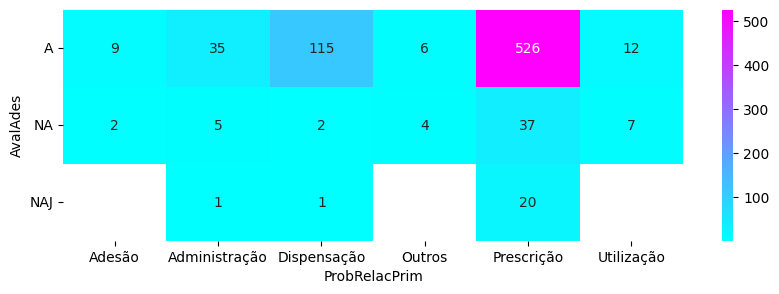

In [210]:
plt.figure(figsize=(10, 3))
sns.heatmap(crosstab_prp_aa.transpose().replace(0, np.nan), cmap='cool', annot=True, fmt=".0f")
#plt.xticks(rotation=25)
plt.yticks(rotation=0)

In [310]:
print('chi2 = ', chi2_contingency(crosstab_prp_aa)[0])
print('p = ', chi2_contingency(crosstab_prp_aa)[1])

chi2 =  3.427749490700395
p =  0.6343471283048031


### 5.2. Correlação entre estratégia primária e avaliação de adesão

In [92]:
crosstab_sip_aa = pd.crosstab(df.AvalAdes, df.StratIntervPrim)
crosstab_sip_aa

StratIntervPrim,Aconselhamento ao paciente,Alteração na prescrição,Informação sobre dispensação,Orientação de administração,Outras intervenções,Sinalização informativa
AvalAdes,,,,,,
A,8,650,9,14,6,16
NAJ,0,22,0,0,0,0


In [93]:
wrapped_labels

['Aconselhamento\nao\npaciente',
 'Alteração\nna\nprescrição',
 'Informação\nsobre\ndispensação',
 'Orientação\nde\nadministração',
 'Outras\nintervenções',
 'Sinalização\ninformativa']

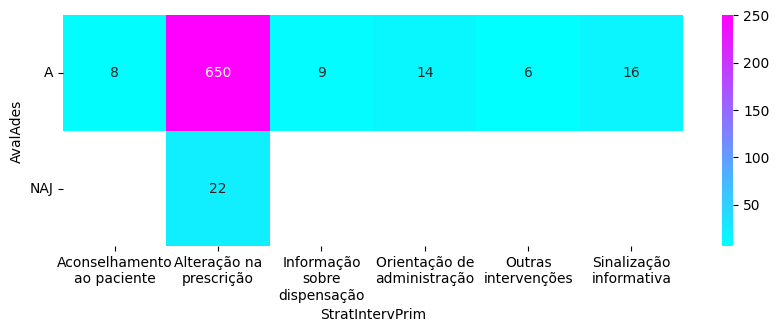

In [105]:
import textwrap

# Create a heatmap
plt.figure(figsize=(10, 3))
ax = sns.heatmap(crosstab_sip_aa.replace(0, np.nan), cmap='cool', annot=True, fmt=".0f", vmax=250)

# Wrap the x-tick labels without cutting words
wrapper = textwrap.TextWrapper(width=15, break_long_words=False)
wrapped_labels = [wrapper.fill(label) for label in crosstab_sip_aa.columns]

# Set the wrapped x-tick labels at their positions and center them
ax.set_xticks([i + 0.5 for i in range(len(crosstab_sip_aa.columns))])
ax.set_xticklabels(wrapped_labels, rotation=0, fontsize=10, ha='center')


# Set y-tick labels
plt.yticks(rotation=0, fontsize=10)

# Show the plot
plt.show()

In [8]:
print('chi2 = ', chi2_contingency(crosstab_sip_aa)[0])
print('p = ', chi2_contingency(crosstab_sip_aa)[1])

chi2 =  1.8147666195190948
p =  0.8741356506190939


### 6. Correlação entre estratégia primária e estratégia secundária

In [ ]:
df.groupby('Strat').count()[['Pac']].sort_values('Pac').plot(kind='barh')

In [314]:
len(np.unique(df.groupby(['StratIntervSec']).count()[['Pac']].sort_values('Pac').index.to_list()))#.head(5).plot(kind='barh')

28

### 7. Distribuição de Idade dos Pacientes

In [303]:
df.Age = np.where(df.Age > 6000, df.Age[df.Age < 6000].mean(), df.Age)

In [357]:
df[['Age']].describe().drop('count')

,Age
mean,68.269133
std,16.433313
min,17.000000
25%,57.000000
50%,68.134566
75%,82.000000
max,103.000000


<Axes: xlabel='Age', ylabel='Count'>

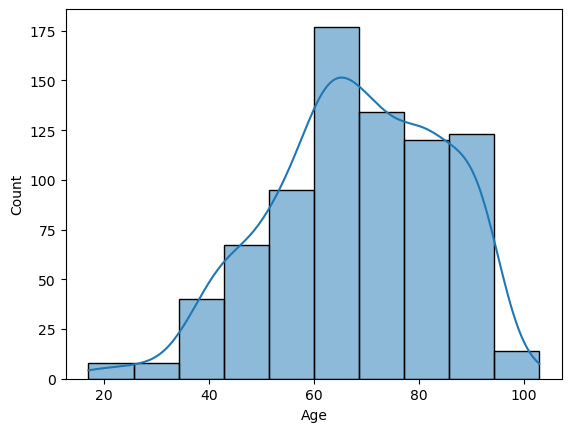

In [352]:
sns.histplot(df.Age, kde=True, bins=10)

<Axes: ylabel='Age'>

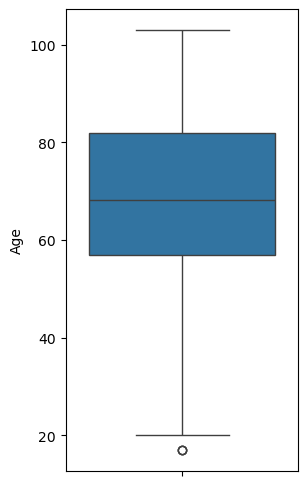

In [349]:
plt.figure(figsize=(3, 6))
sns.boxplot(df.Age)

In [219]:
import scipy.stats as stats

In [26]:
df.pivot_table(index='medEnv', values='Age', aggfunc='mean')

,Age
medEnv,
Abiraterona,91.000000
Acetilcisteína,60.500000
Agua para injetáveis,90.000000
Albendazol,82.000000
Alopurinol,78.000000
...,...
Zolpidem,74.333333
Ácido tranexâmico,63.666667
Ácido zoledrônico,78.000000


In [222]:
age_groups = [df[['Age']][df['medEnv'] == group] for group in df['medEnv'].unique() if df['medEnv'][df['medEnv'] == group].count() >= 2]

f_statistic, p_value = stats.f_oneway(*age_groups)
f_statistic, p_value

(array([2.39796967]), array([1.29965888e-09]))

In [223]:
df['medEnv'].unique()

array(['Ácido zoledrônico', 'Bromoprida', 'Dipirona', 'Fenitoína',
       'Hidrocortisona', 'Lactulose', 'Metadona', 'Morfina',
       'Paracetamol ', 'Piperacilina + tazobactam', 'Vancomicina', nan,
       'Amitriptilina', 'Anlodipino', 'Atropina', 'Bisacodil',
       'Budesonida', 'Ceftriaxona', 'Clonazepam', 'Cloreto de sódio 0,9%',
       'Cloreto de sódio 20%', 'Clorpromazina', 'Dimenidrato',
       'Dipirona ', 'Domperidona', 'Fenitoína ', 'Fentanil', 'Fentanila',
       'Fluconazol', 'Gabapentina', 'Glicose 50% ', 'Haloperidol',
       'Ibuprofeno', 'Ipratropio', 'Itraconazol', 'Levomepromazina',
       'Levotiroxina', 'Loperamida', 'Loratadina ', 'Metoclopramida',
       'Metoprolol', 'Metronidazol', 'Midazolam', 'Morfina ',
       'Nortriptilina', 'Omeprazol', 'Paracetamol', 'Propatilnitrato',
       'Valproato de sódio', 'Zolpidem', 'Agua para injetáveis',
       'Amoxicilina', 'Ampicilina + sulbactam', 'Bromoprida ',
       'Budesonida + formoterol', 'Carbamazepina', 'Carved

In [226]:
df_dropped = df[df.medEnv.apply(lambda x: x == x)]

grouped_data = [(df_dropped[df_dropped['medEnv'] == group]['Age'].values) for group in df_dropped['medEnv'].unique()]
#grouped_data
F_statistic, p_value = stats.f_oneway(*grouped_data)
p_value

1.3594150014968015e-07

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Fenitoína'),
  Text(1, 0, 'Dimenidrato'),
  Text(2, 0, 'Amitriptilina'),
  Text(3, 0, 'Metformina'),
  Text(4, 0, 'Olanzapina'),
  Text(5, 0, 'Piperacilina + tazobactam')])

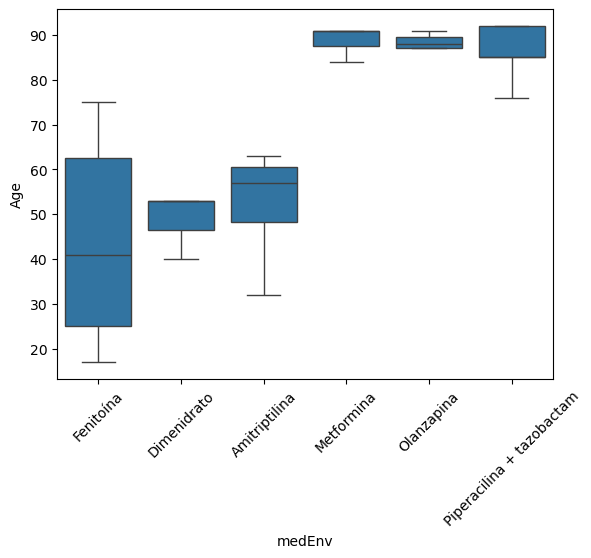

In [297]:
df_gby_me = df.pivot_table(index='medEnv', values= 'Age', aggfunc=['mean', 'count'])#.head(10).index.to_list()#.sort_values('count')
bot_5 = df_gby_me[df_gby_me[('count', 'Age')]>=3 ].sort_values(('mean', 'Age')).head(3).index.to_list()
top_5 = df_gby_me[df_gby_me[('count', 'Age')]>=3 ].sort_values(('mean', 'Age'), ascending=False).head(3).index.to_list()
#filtered_groups = df_gby_me[df_gby_me['Pac'] >= 4].index.to_list()
#top_10 = df_gby_me[df_gby_me['Pac'] >= 4].index.to_list()
#top_10
sns.boxplot(data=df[df['medEnv'].isin(bot_5 + top_5)], x='medEnv', y ='Age', order = bot_5 + top_5)
plt.xticks(rotation=45)

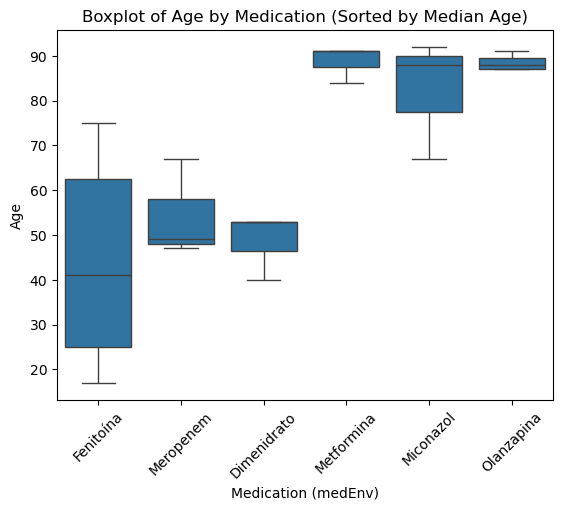

In [296]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your existing DataFrame with 'medEnv' and 'Age' columns

# Step 1: Create the pivot table and calculate median age
df_gby_me = df.pivot_table(index='medEnv', values='Age', aggfunc=['median', 'count'])

# Step 2: Get bottom 3 and top 3 medication groups by median age (with at least 3 entries)
bot_5 = df_gby_me[df_gby_me[('count', 'Age')] >= 3].sort_values(('median', 'Age')).head(3).index.to_list()
top_5 = df_gby_me[df_gby_me[('count', 'Age')] >= 3].sort_values(('median', 'Age'), ascending=False).head(3).index.to_list()

# Step 3: Create the box plot for the selected medication groups
#plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['medEnv'].isin(bot_5 + top_5)], x='medEnv', y='Age', order=bot_5 + top_5)
plt.title('Boxplot of Age by Medication (Sorted by Median Age)')
plt.xlabel('Medication (medEnv)')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()


In [290]:
[bot_5 + top_5]

[['Fenitoína',
  'Dimenidrato',
  'Amitriptilina',
  'Dimenidrinato',
  'Meropenem',
  'Metformina',
  'Olanzapina',
  'Piperacilina + tazobactam',
  'Metoprolol',
  'Duloxetina']]

### Idade por grupo

In [298]:
df[df[]][['Age']].describe().drop('count')

,Age
mean,68.269133
std,16.433313
min,17.000000
25%,57.000000
50%,68.134566
75%,82.000000
max,103.000000


In [304]:
df.pivot_table(index='UniClin', values='Age', aggfunc='mean')

,Age
UniClin,
A,64.187919
C,81.071254


<Axes: xlabel='Age', ylabel='Count'>

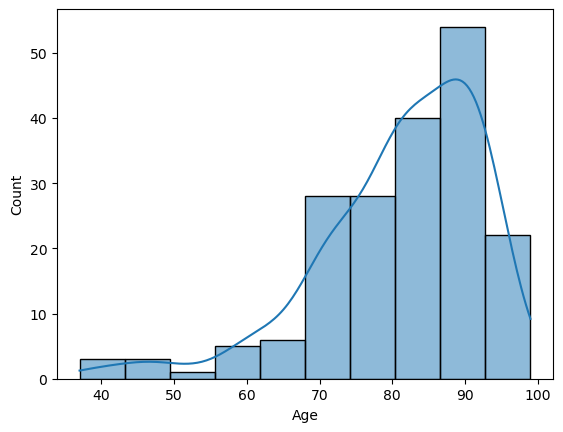

In [309]:
sns.histplot(df[df['UniClin'] == 'C']['Age'], kde=True, bins=10)

In [1]:
plt.figure(figsize=(4, 6))
sns.boxplot(df, x='UniClin', y='Age')

NameError: name 'plt' is not defined

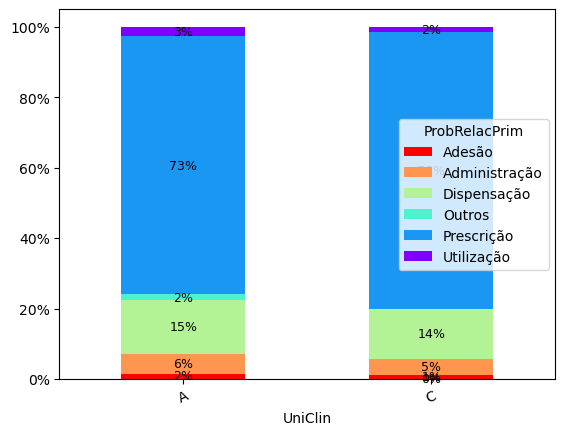

In [104]:
ax = pd.crosstab(df.UniClin, df.ProbRelacPrim, normalize='index')\
    .plot(kind='bar', stacked=True, colormap='rainbow_r')

#df.pivot_table(index='UniClin', columns='ProbRelacPrim', values='Pac', aggfunc='count')\
#    .plot(kind='bar', stacked=True, colormap='plasma')

for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='{:.0%}', fontsize=9, color='black')
    
plt.xticks(rotation=25)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Aconselhamento ao paciente'),
  Text(1, 0, 'Alteração na prescrição '),
  Text(2, 0, 'Informação sobre dispensação'),
  Text(3, 0, 'Orientação de administração '),
  Text(4, 0, 'Outras intervenções '),
  Text(5, 0, 'Sinalização informativa')])

<Figure size 20000x3000 with 0 Axes>

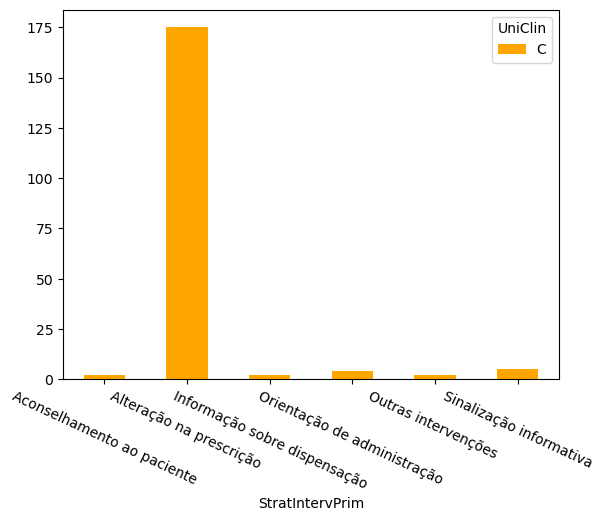

In [61]:
plt.figure(figsize=(200, 30))

df.pivot_table(index='StratIntervPrim', columns='UniClin', values='Pac', aggfunc='count')[['C']]\
    .plot(kind='bar', stacked=True, color='orange')

plt.xticks(rotation=-25)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Aconselhamento ao paciente'),
  Text(1, 0, 'Alteração na prescrição '),
  Text(2, 0, 'Informação sobre dispensação'),
  Text(3, 0, 'Orientação de administração '),
  Text(4, 0, 'Outras intervenções '),
  Text(5, 0, 'Sinalização informativa')])

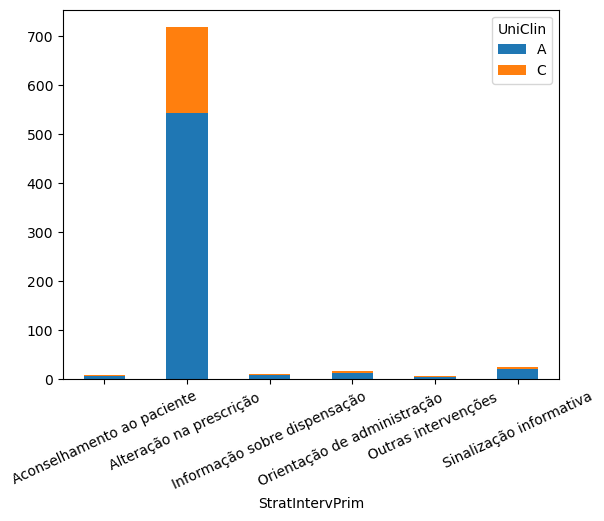

In [59]:
df.pivot_table(index='StratIntervPrim', columns='UniClin', values='Pac', aggfunc='count')\
    .plot(kind='bar', stacked=True)

plt.xticks(rotation=25)

In [57]:
from matplotlib import pyplot as plt

<Axes: ylabel='medEnv'>

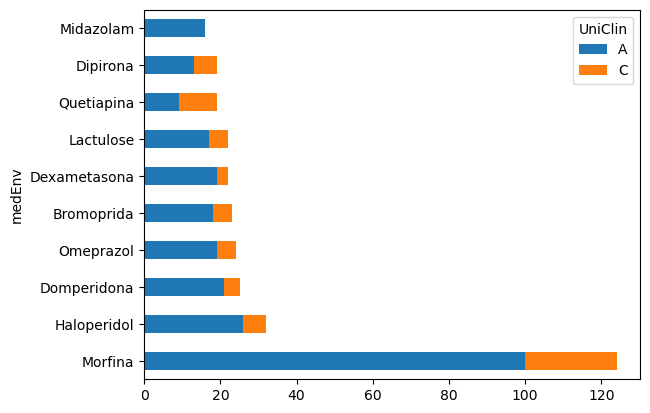

In [132]:
df_dropped = df[df.medEnv.apply(lambda x: x == x)]

#grouped_data = [(df_dropped[df_dropped['medEnv'] == group]['Age'].values) for group in df_dropped['medEnv'].unique()]
#grouped_data
#F_statistic, p_value = stats.f_oneway(*grouped_data)
#p_value

df_med = df.pivot_table(index='medEnv', columns='UniClin', values='Pac', aggfunc='count', margins='index')\
    .sort_values('All', ascending=False)

df_med[['A', 'C']].head(11).tail(10).plot(kind='barh', stacked=True)

### IFs Aceitas


([<matplotlib.axis.YTick at 0x7ff7428b7110>,
 [Text(0, 0, 'Não Aderido \n Justificado'),
  Text(0, 1, 'Não Aderido'),
  Text(0, 2, 'Aderido')])

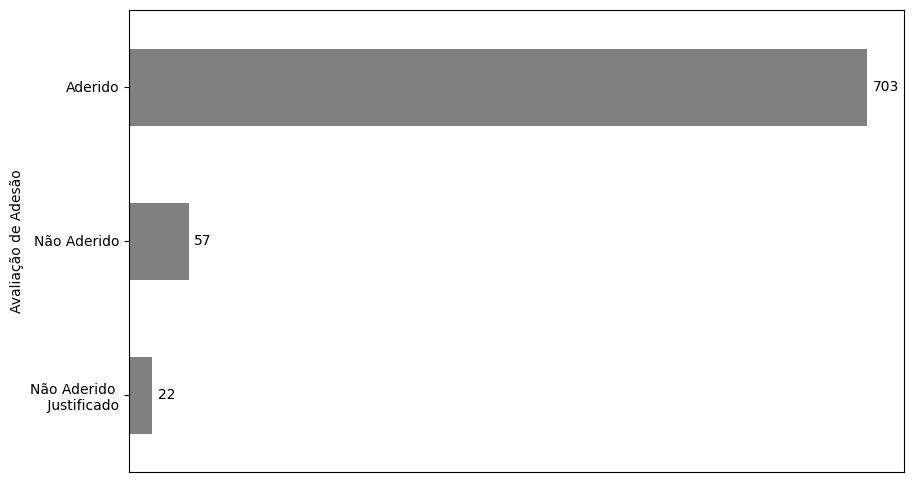

In [50]:
#

ax = df.pivot_table(values='Pac', index='AvalAdes', aggfunc='count').sort_values('Pac').plot(kind='barh', figsize=(10, 6), legend=False, color='grey')

# Annotating the bars
for bar in ax.patches:
    ax.annotate(
        f'{int(bar.get_width())}',  # Label text (converts bar width to integer)
        (bar.get_width()+ 5, bar.get_y() + bar.get_height() / 2),  # Position (x, y)
        ha='left', va='center', fontsize=10  # Alignment and font size
    )

ax.set_xticks([])


ax.set_xticks([])  # Remove x-ticks
plt.ylabel('Avaliação de Adesão')

# Custom y-ticks
plt.yticks(
    range(len(ax.get_yticklabels())),  # Numeric positions
    ['Aderido', 'Não Aderido', 'Não Aderido \n Justificado'][::-1]  # Custom labels
)


### Pivot Table


In [4]:
df['AvalAdes'].replace(np.nan, 'NA', inplace=True)

/tmp/ipykernel_695/597867183.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['AvalAdes'].replace(np.nan, 'NA', inplace=True)


In [5]:
freqreldict = {}
for ProbRelacPrim in np.unique(df.ProbRelacPrim.to_list()):

    freqrel = 1/df[df['ProbRelacPrim'] == ProbRelacPrim].Pac.count()
    freqreldict[str(ProbRelacPrim)] = freqrel

freqreldict

df['FreqRel'] = df.ProbRelacPrim.map(freqreldict)

In [8]:
np.unique(df.AvalAdes.to_list())

array(['A', 'NA', 'NAJ'], dtype='<U3')

In [9]:
true_pivot = df.pivot_table(index=['ProbRelacPrim', 'ProbRelacSec'], values=['FreqRel', 'Pac'], aggfunc={'FreqRel': 'sum', 'Pac': 'count'})[['Pac', 'FreqRel']]

In [10]:
aval_pivot = df.pivot_table(index=['ProbRelacPrim', 'ProbRelacSec'], columns='AvalAdes', values='Pac', aggfunc='count')
aval_pivot.replace(np.nan, 0, inplace=True)
aval_pivot['AdesRate'] = (aval_pivot['A'])/(aval_pivot['A'] + aval_pivot['NAJ']+ aval_pivot['NA'])

In [11]:
aval_pivot

AvalAdes                                                              A    NA  \
ProbRelacPrim ProbRelacSec                                                      
Adesão         Automedicação indevida pelo paciente                 4.0   0.0   
               Descontinuação indevida do medicamento pelo pa...    0.0   1.0   
               Falta de adesão ao tratamento pelo paciente          4.0   0.0   
               Problema de acesso à medicação                       1.0   1.0   
Administração  Conservação/preparo inadequado (diluente/estab...    1.0   1.0   
               Dose/concentração inadequada                         4.0   0.0   
               Horário/frequência inadequada                        3.0   0.0   
               Incompatibilidade medicamentosa contraindicada       5.0   0.0   
               Omissão de doses (subdosagem)                        5.0   1.0   
               Outros problemas de administração                    9.0   0.0   
               Via inadequada                                       8.0   0.0   
              Medicamento inapropriado ou contraindicado            0.0   3.0   
Dispensação    Dose/quantidade incorreta                            2.0   0.0   
               Falta no estoque                                   101.0   1.0   
               Forma farmacêutica incorreta                         2.0   0.0   
               Medicamento incorreto                                1.0   0.0   
               Outros problemas de dispensação                      7.0   1.0   
               Outros problemas de prescrição                       2.0   0.0   
Outros         (descrever na coluna "Observações")                  1.0   4.0   
               Disponibilidade de alternativa medicamentosa m...    1.0   0.0   
               Prescrito medicamento não-padronizado                2.0   0.0   
               Reação adversa importante                            2.0   0.0   
Prescrição     Disponibilidade de alternativa medicamentosa m...    8.0   0.0   
               Dose abaixo das recomendações (subdose)             44.0   3.0   
               Dose acima das recomendação (sobredose)             41.0   6.0   
               Duração do tratamento prescrita inadequada          14.0   0.0   
               Falta no estoque                                     4.0   0.0   
               Forma farmacêutica ou via de administração pre...   82.0  13.0   
               Frequência ou horários de administração prescr...   24.0   0.0   
               Medicamento sem indicação clínica definida          11.0   2.0   
               Omissão de doses (subdosagem)                        1.0   0.0   
               Outros problemas de prescrição                     130.0   4.0   
               Outros problemas de utilização                       1.0   0.0   
               Possível incompatibilidade medicamentosa contr...    2.0   0.0   
               Possível interação medicamento-alimento import...    3.0   0.0   
               Possível interação medicamento-medicamento con...   14.0   0.0   
               Possível interação medicamento-medicamento grave     1.0   0.0   
               Prescrito medicamento não-padronizado               21.0   0.0   
               Via inadequada                                       0.0   1.0   
              Medicamento em duplicidade na prescrição             17.0   0.0   
              Medicamento inapropriado ou contraindicado           23.0   1.0   
              Necessidade de medicamento adicional                 85.0   7.0   
Utilização     Efeitos de descontinuação de um medicamento          1.0   0.0   
               Horário/frequência inadequada                        0.0   1.0   
               Interação medicamento-medicamento contraindica...    2.0   6.0   
               Outros problemas de utilização                       5.0   0.0   
               Reação adversa importante                            4.0   0.0   

AvalAdes                      

In [12]:
true_pivot = true_pivot.join(aval_pivot).drop(columns=['A', 'NA', 'NAJ'])#, inplace=True)

In [13]:
sub_pivot = df.pivot_table(index='ProbRelacPrim', values=['FreqRel', 'Pac'], aggfunc={'FreqRel': 'sum', 'Pac': 'count'})[['Pac', 'FreqRel']]
sub_pivot

,Pac,FreqRel
ProbRelacPrim,,
Adesão,11,1.0
Administração,41,1.0
Dispensação,118,1.0
Outros,10,1.0
Prescrição,583,1.0
Utilização,19,1.0


In [14]:
sub_aval_pivot = df.pivot_table(index=['ProbRelacPrim'], columns='AvalAdes', values='Pac', aggfunc='count')
sub_aval_pivot.replace(np.nan, 0, inplace=True)
sub_aval_pivot['AdesRate'] = (sub_aval_pivot['A'])/(sub_aval_pivot['A'] + sub_aval_pivot['NAJ']+ sub_aval_pivot['NA'])
sub_aval_pivot

AvalAdes,A,NA,NAJ,AdesRate
ProbRelacPrim,,,,
Adesão,9.0,2.0,0.0,0.818182
Administração,35.0,5.0,1.0,0.853659
Dispensação,115.0,2.0,1.0,0.974576
Outros,6.0,4.0,0.0,0.600000
Prescrição,526.0,37.0,20.0,0.902230
Utilização,12.0,7.0,0.0,0.631579


In [15]:
sub_pivot = sub_pivot.join(sub_aval_pivot, on=['ProbRelacPrim']).drop(columns=['A', 'NA', 'NAJ'])

In [16]:
sub_pivot['ProbRelacSec'] = ''
sub_pivot.reset_index(inplace=True)
sub_pivot.set_index(['ProbRelacPrim', 'ProbRelacSec'], inplace=True)

#pd.concat([true_pivot, sub_pivot])

In [17]:
final_pivot = pd.concat([true_pivot, sub_pivot]).sort_values(['ProbRelacPrim', 'ProbRelacSec'])
final_pivot.rename(columns={'Pac': 'Frequência Absoluta', 'FreqRel': 'Frequência Relativa', 'AdesRate': 'Taxa de Adesão'}, inplace=True)

In [18]:
import os
os.environ['PATH']

'/bin:/var/data/python/bin:/app/bin:/app/bin:/app/bin:/usr/bin:/home/salgado/.var/app/com.visualstudio.code/data/node_modules/bin:/app/bin:/app/bin:/app/bin:/usr/bin:/home/salgado/.var/app/com.visualstudio.code/data/node_modules/bin'

In [19]:
downloads = os.environ['HOME']+'/Downloads/'

final_pivot.to_excel(downloads + "pivot1.xlsx")

### Gráfico de Adesão

In [20]:
df_years = df.pivot_table(index='year', columns='AvalAdes', values='Pac', aggfunc='count')
df_years.replace(np.nan, 0, inplace=True)

df_years['Total'] = df_years['A'] + df_years['NA'] + df_years['NAJ']
df_years['AdesRate'] = df_years['A']/df_years['Total']*100

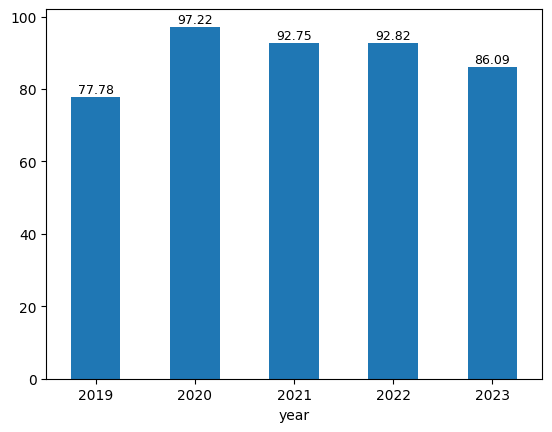

In [21]:
# Plotando o gráfico de barras
ax = df_years.plot(y='AdesRate', kind='bar', legend=False)

# Ajustando os rótulos no eixo X
plt.xticks(rotation=0)

# Adicionando os valores nas barras
for i, value in enumerate(df_years['AdesRate']):
    # Posicionando o texto no topo de cada barra
    plt.text(i, value + 0.2, str(round(value, 2)), ha='center', va='bottom', fontsize=9)


(0.0, 400.0)

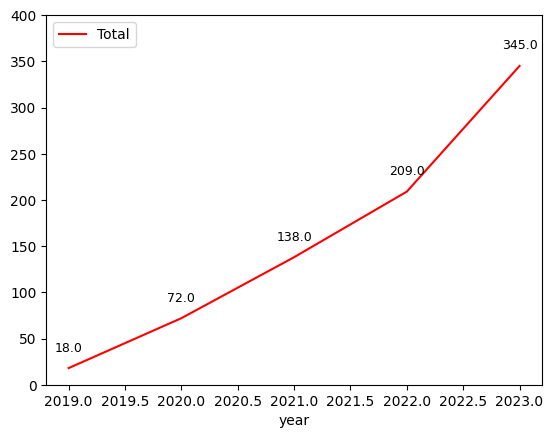

In [22]:
df_years.plot(y='Total', kind='line', color='red')

for i, value in enumerate(df_years['Total']):
    plt.text(df_years.index[i], value+15, str(value), ha='center', va='bottom', fontsize=9)

plt.ylim(0, 400)

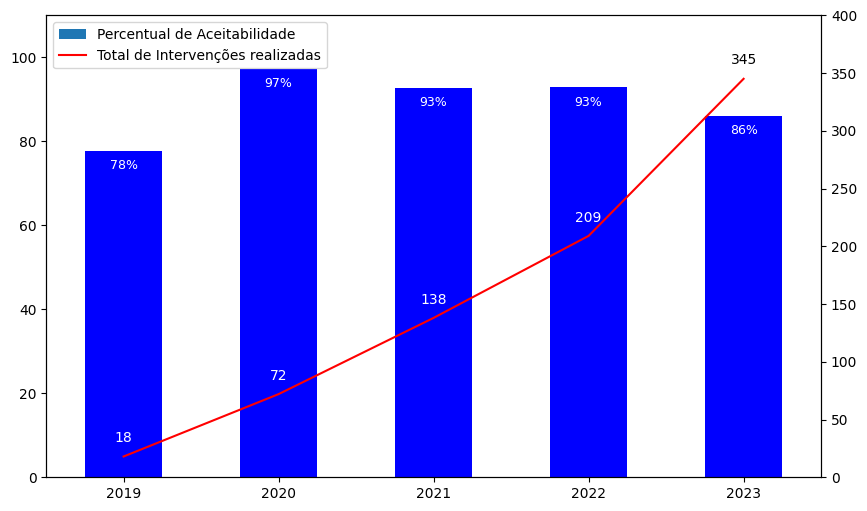

In [23]:
import matplotlib.pyplot as plt

# Create the primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar chart on ax1
df_years.plot(y='AdesRate', kind='bar', legend=False, ax=ax1, color='blue')

# Set x-ticks rotation
plt.xticks(rotation=0)
plt.xlabel('')

# Add value labels to the bars
for i, value in enumerate(df_years['AdesRate']):
    ax1.text(i, value - 5, f'{str(round(value))}%', ha='center', va='bottom', fontsize=9, color='white')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the line chart on ax2
df_years.reset_index().plot(y='Total', kind='line', color='red', ax=ax2, legend=False)

# Add value labels to the line chart
for i, value in enumerate(df_years.reset_index()['Total']):
    ax2.text(i, value + 10, str(round(value)), ha='center', va='bottom', fontsize=10, color='white')

ax2.text(i, value + 10, str(round(value)), ha='center', va='bottom', fontsize=10, color='black')


# Set limits for y-axes
ax1.set_ylim(0, 110)  # Adjust for AdesRate
ax2.set_ylim(0, 400)  # Adjust for Total

# Set x-axis limits
ax1.set_xlim(-0.5, len(df_years) - 0.5)  # Dynamically adjust based on data length

# Add legends manually
bar_legend = ax1.bar([], [], color='blue', label='Percentual de Aceitabilidade')
line_legend, = ax2.plot([], [], color='red', label='Total de Intervenções realizadas')

ax1.legend(handles=[bar_legend, line_legend], loc='upper left', fontsize=10)


(1.0, 2.02)

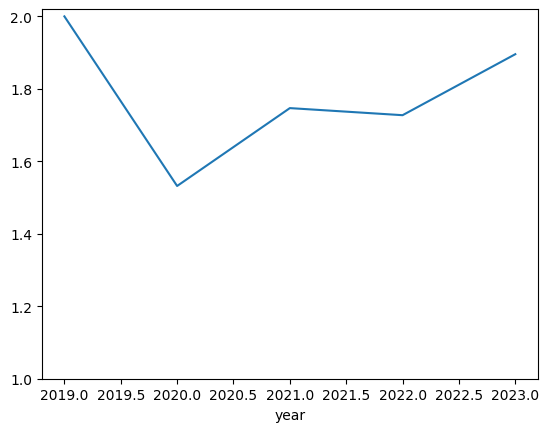

In [41]:
df.pivot_table(index='NumSes', values='Pac', columns='year',aggfunc='count').mean().plot(kind='line')
plt.ylim(1, 2.02)